## Tutorial 03: visualisation of velocities

**After processing (tutorial 01) and calculating the velocities (tutorial 02), in this tutorial we will explain and show how to visualise the high-dimensional velocity vectors on a low dimensional embedding, s.a. suggested in the $\kappa$-velo pipeline. The methods used here are described in far more detail in section 2.2 of our bioRxiv preprint (Marot-Lassauzaie and Bouman, et al. 2022). In this tutorial, we first generate the low dimensional embedding of the cells, then we project the velocities on the embedding. In this notebook we will focus on a few different embeddings (PCA, t-SNE, UMAP) to get a feeling for how they transform the data.**

Note: for speedup in this tutorial we start from an object with pre-computed velocities. This object is saved at the end of tutorial 02. 

*Initiation data: Thursday 26.05.2022*\
*Lastest update: Sunday 29.05.2022*\
*Author: Valérie Marot-Lassauzaie (valerie.marot-lassauzaie@mdc-berlin.de)*


In [1]:
### load libraries

# standard libraries
import numpy as np

# single-cell libraries
import anndata as ad

# plotting libraries
import matplotlib.pyplot as plt

# dimension reductions
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
from sklearn.manifold import TSNE
import umap

from scipy.spatial import cKDTree

# import our own functions
%cd ..
from scripts.kappavelo import *
from scripts.visualisation import *

/Users/vmarotl/Documents/rna_velocity/cell-state-velocities


### Load dataset

For speedup in this tutorial we start from an object with pre-computed velocities. This object was made using a single-cell dataset of pancreas differentiation published by Bastidas-Ponce and colleagues in 2019 (https://doi.org/10.1242/dev.173849). We refer you to tutorial 01 for more explanation on the dataset. For more information about the calculation of the velocities have a look at tutorial 02. 

If you have your own dataset with precomputed velocities you can change the path to wherever you object is stored.

In [2]:
### load pancreas dataset with calculated velocities
dataset_path = "datasets/pancreas/pancreas_velocities_calculated.h5ad"
adata = ad.read_h5ad(dataset_path)

Before starting with creating the velocity plots, we will first save the colors that are assigned to each cell based on it's cell type in the Anndata object. These colors will be used to color the arrows in the velocity plots. Additionally, we create a lighter version of that color, which we will use to color the base of the arrow (where you would normally see the cell). Saving these colors makes it a lot easier to analyze the velocity plots later.

In [3]:
### get colors of each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
cell_colors=adata.obs["clusters"].map(color_dict)
light_color = np.array([lighten_color(i, .3) for i in cell_colors])

### PCA

**About PCA**\
PCA is the most reliable low-dimensional embedding. Since PCA is a linear transformation it generally respects both short and long pairwise distances better than non-linear approaches such as UMAP and t-SNE. However, PCA often fails to fully capture the data in only two dimensions, especially when the data is rather complex. Therefore, To have a look this, you can look at how much variance is captures by the first $k$ principal components (PCs).

**Velocity plot using PCA**\
To create a velocity plot in a PCA dimension reduction we start with creating the low dimension embedding. In this example we calculate the PCA on the imputed spliced counts. We will calculate the first 15 principal components (PCs). 

In [4]:
### scale data (imputed spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["Ms"])

In [5]:
### run PCA
np.random.seed(0)
n_pcs = 15
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

Now we will have a look at the variance in each PC. This is a standard practice in PCA and it gives us some insight into how important each PC is for describing the data. 

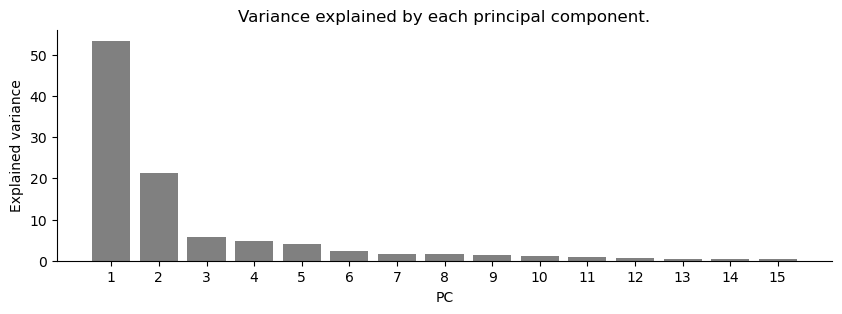

In [6]:
### plot variances of each PC
fig, ax = plt.subplots(figsize=(10, 3))

plt.bar(np.arange(0, 15), pca.explained_variance_, color="grey")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks(np.arange(0, 15), np.arange(1, 16))
plt.xlabel("PC")
plt.ylabel("Explained variance")
plt.title("Variance explained by each principal component.")

plt.show()

Based on this histogram, we can see that in this dataset, most of the variance is covered by the first two PCs. So let's have a look! We'll also have a look at PC3 to be sure that we do not miss anything. In this case the points are projected onto 3 dimensions (= a cube).

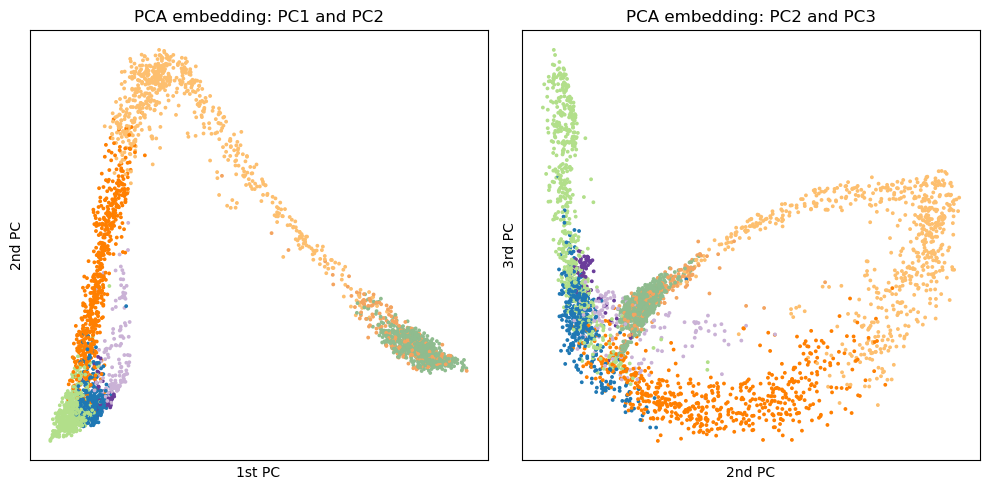

In [7]:
### plot PCs 1,2 and 3
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(pca_pts[:,0], pca_pts[:,1], color=cell_colors, s=3)
axs[1].scatter(pca_pts[:,1], pca_pts[:,2], color=cell_colors, s=3)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

# axis labels
axs[0].set_xlabel("1st PC")
axs[0].set_ylabel("2nd PC")
axs[1].set_xlabel("2nd PC")
axs[1].set_ylabel("3rd PC")
# title
axs[0].set_title("PCA embedding: PC1 and PC2")
axs[1].set_title("PCA embedding: PC2 and PC3")

fig.tight_layout()

plt.show()

**Projection of the velocities onto PCA**\
Since PCA is a linear transformation, we can simply apply the same transformation onto the future states.\
From the spliced counts $S$ future states are defined as $S_{fut}=S+\vec V$. Meaning that we add the velocity vectors found in tutorial 02 to the spliced counts.

In [8]:
### create future states
S_fut = adata.layers["Ms"]+adata.layers["velocity"]

In [9]:
### scale in the same way as we scaled S
S_fut_scaled = scal.transform(S_fut)

In [10]:
### apply pre-trained PCA transformation on scaled future states
pca_pts_fut = pca.transform(S_fut_scaled)

For ease of plotting we need the velocity vector. In the plotting function the arrows are drawn from a point to the same pt + v.

In [11]:
### get velocity vector in PCA space
pca_v = pca_pts_fut-pca_pts

We down scale the velocities so that the plot is easy to assess visually. Especially when you are working with your own dataset, you probably need to fine tune this value manually a bit.

In [14]:
down_scale = 10
pca_v_scaled = pca_v*down_scale

Let's make the PCA plots with the velocities included!

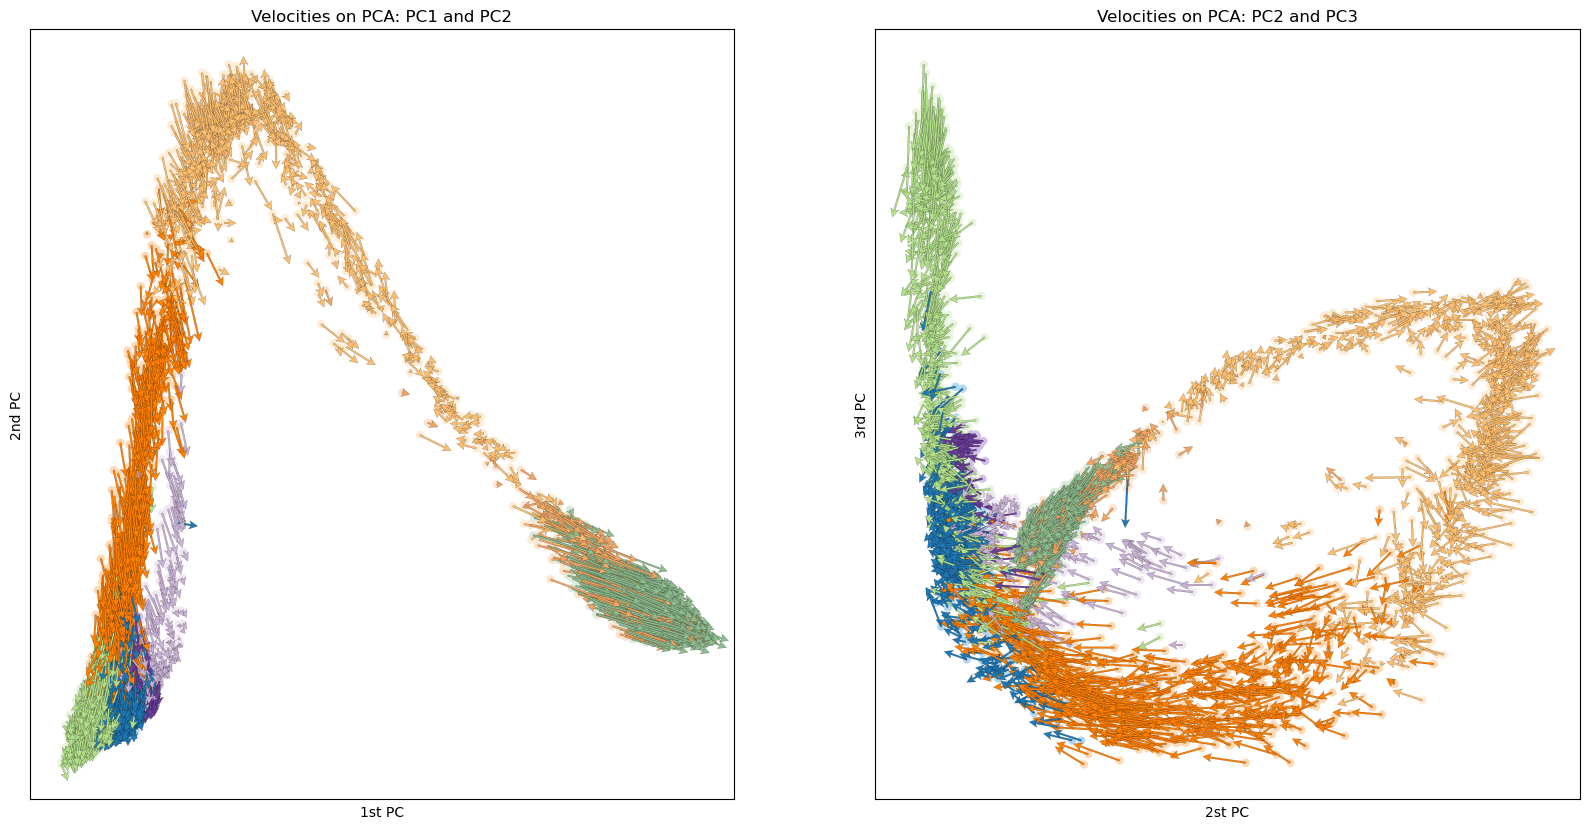

In [15]:
### set arguments for plotting
pltkwargs={"figsize":(10, 6), "frameon":False}
sub = np.arange(0, adata.shape[0], 1)
pca_quiver_kwargs = {"scale": .8, "angles": "xy", "scale_units": "xy", "edgecolors": "k",
                     "linewidth": 0.1, "headwidth": 5, "headaxislength": 4}

### create PCA plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].scatter(pca_pts[:,0], pca_pts[:,1], color=light_color, s=25)
axs[1].scatter(pca_pts[:,1], pca_pts[:,2], color=light_color, s=25)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

# axis labels
axs[0].set_xlabel("1st PC")
axs[0].set_ylabel("2nd PC")
axs[1].set_xlabel("2st PC")
axs[1].set_ylabel("3rd PC")

# title
axs[0].set_title("Velocities on PCA: PC1 and PC2")
axs[1].set_title("Velocities on PCA: PC2 and PC3")

# plot arrows 
axs[0].quiver(pca_pts[:,0], pca_pts[:,1], pca_v_scaled[:,0], pca_v_scaled[:,1], 
              color=cell_colors, **pca_quiver_kwargs)
axs[1].quiver(pca_pts[:,1], pca_pts[:,2], pca_v_scaled[:,1], pca_v_scaled[:,2], 
              color=cell_colors, **pca_quiver_kwargs)

plt.show()

**Smoothing**\
The high dimensionality vectors are quite noisy. This informs us on cell plasticities, as well as fluctuations of the dynamics. However, it can sometimes be a bit difficult to see overall tendencies. Because of this, it can be interesting to smooth out the arrows, and get a look at more general trends. One way to do this is simply to average over neighbourhoods in PCA space.

In [16]:
### get top 30 nearest neighbors
NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]

<ipython-input-16-fb12c6d4a1d7>:2: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]


In [17]:
### average velocities over neighbourhoods
pca_v_mean = np.nanmean(np.array(pca_v_scaled)[NN], axis=1)

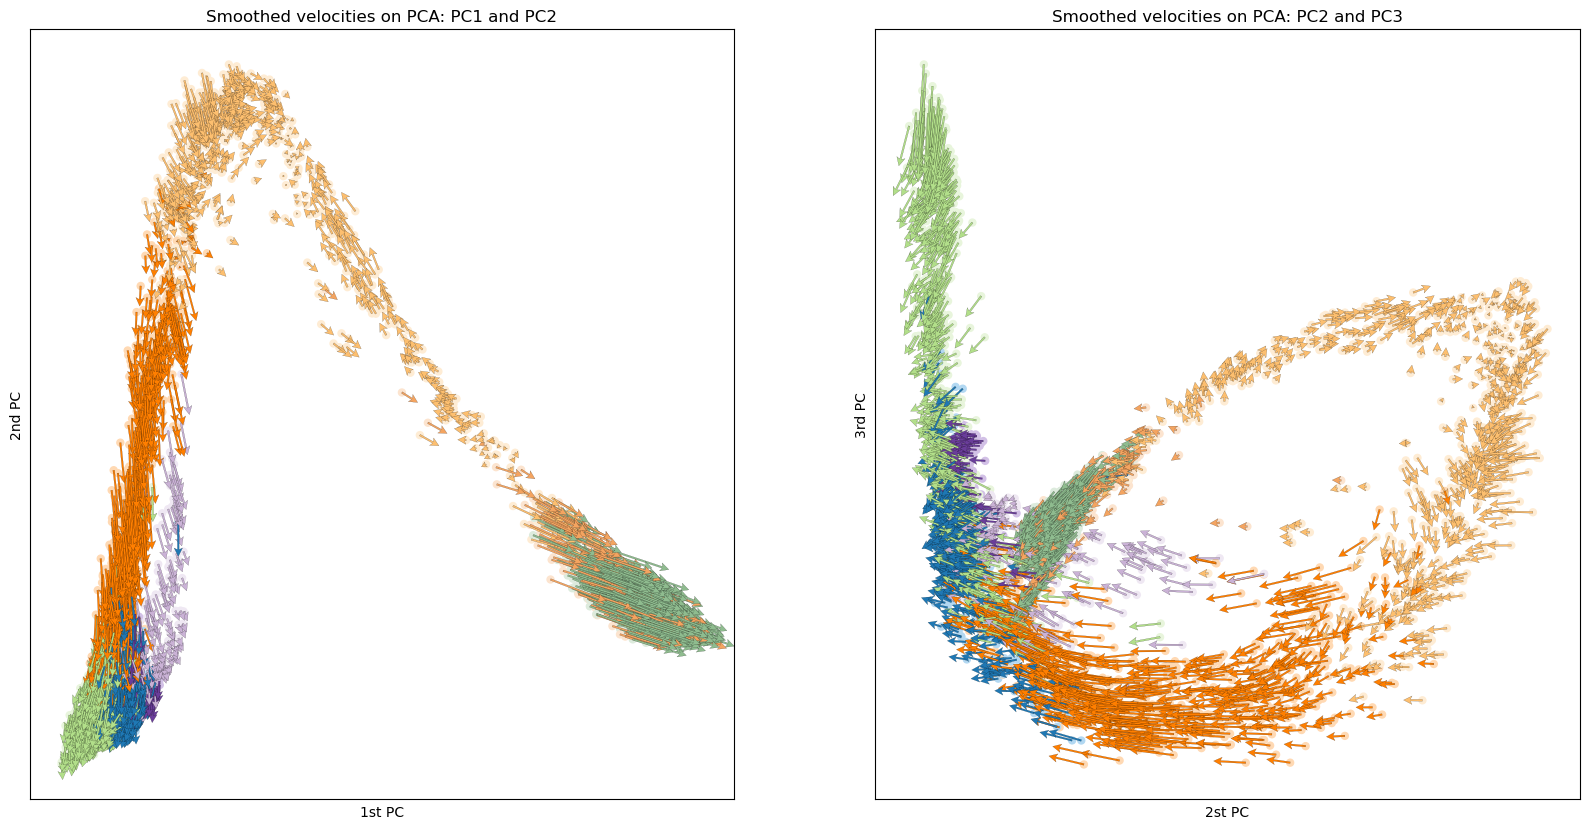

In [18]:
### create PCA plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].scatter(pca_pts[:,0], pca_pts[:,1], color=light_color, s=25)
axs[1].scatter(pca_pts[:,1], pca_pts[:,2], color=light_color, s=25)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

# axis labels
axs[0].set_xlabel("1st PC")
axs[0].set_ylabel("2nd PC")
axs[1].set_xlabel("2st PC")
axs[1].set_ylabel("3rd PC")

# title
axs[0].set_title("Smoothed velocities on PCA: PC1 and PC2")
axs[1].set_title("Smoothed velocities on PCA: PC2 and PC3")

# plot arrows 
axs[0].quiver(pca_pts[:,0], pca_pts[:,1], pca_v_mean[:,0], pca_v_mean[:,1], 
              color=cell_colors, **pca_quiver_kwargs)
axs[1].quiver(pca_pts[:,1], pca_pts[:,2], pca_v_mean[:,1], pca_v_mean[:,2], 
              color=cell_colors, **pca_quiver_kwargs)

plt.show()

Ok, now that we have had a look at the velocites on PCA, and gotten a first look at what is going on here, it is time to have a look at more complex embedding. High-dimensional data might not always be linearly projected onto 2, or even 3 dimensions. Because of this people have developed workarounds, to try to map high-dimensional data onto 2D using non-linear projection, s.a. [t-SNE](https://www.jmlr.org/papers/v9/vandermaaten08a.html) or [UMAP](https://arxiv.org/abs/1802.03426).

It is important to note that such transformations will always distort the data, and cannot be taken to be a completely true representation. Think for example of the surface of a sphere (like the earth), no matter how you try to squish this onto a 2D map, the distances between some point will not correspond to their real distance in 3D (like in the Azimuthal projection of the earth). 

### t-SNE
**About t-SNE**\
[t-SNE](https://www.jmlr.org/papers/v9/vandermaaten08a.html) has one parameter "perplexity", that characterizes the size of the kernel. Changing the perplexity parameter will make the cells separate more or cluster in a more continuous process. Let's have a look!

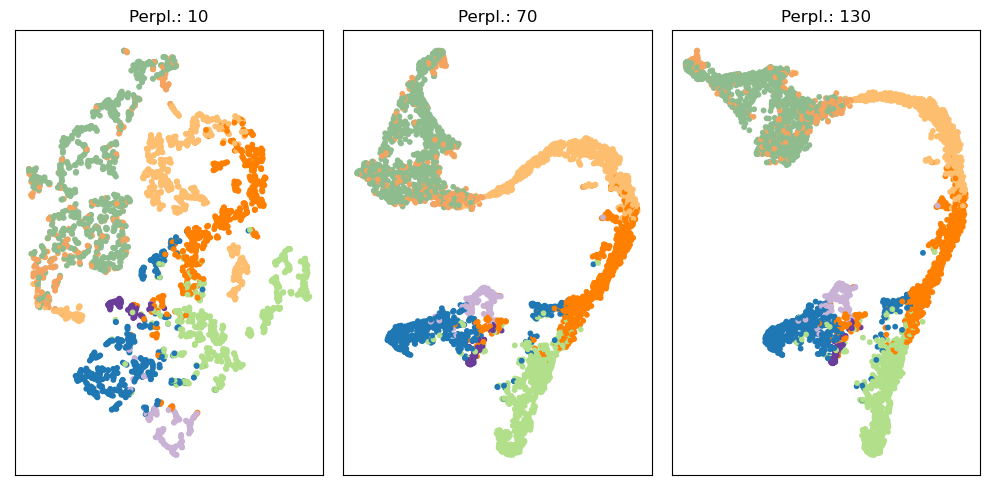

In [19]:
### set seed
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for i, perplexity in enumerate(np.arange(10, 140, 60)):
    np.random.seed(1) # for reproducibility
    tSNE_data = TSNE(n_components=2, random_state=2, perplexity=perplexity).fit_transform(pca_pts)
    axs[i].scatter(tSNE_data[:,0], tSNE_data[:,1], color=cell_colors, s=10)
    axs[i].set_xticks([]), axs[i].set_yticks([])
    axs[i].set_title("Perpl.: " +str(perplexity))
plt.tight_layout()
plt.show()

In RNA velocity, we want to analyse trajectories. Because of this we will chose a setting in which the cells are arranged in a nice lineage without breaks. Note that this might not always be possible if you have very distinct cell types.

In [20]:
tSNE_data = TSNE(n_components=2, random_state=2, perplexity=130).fit_transform(pca_pts)

Projecting points onto an existing non-linear embedding is not trivial, as we cannot directly recover the transformation that brought the points into this low-D space. We try to approximate this transformation based on the nyström projection. Please refer to our [manuscript](https://www.biorxiv.org/content/10.1101/2022.03.17.484754v1) section 2.2. for more details.

In [22]:
### calculate projection of velocities onto embedding (kappa-velo method)
tSNE_fut = project_velocities(tSNE_data, pca_pts, pca_pts_fut, n_neighbors=100)
tSNE_v = tSNE_fut - tSNE_data 

Scaling velocities, set "force_no_scale=True" to stop this.
Projecting velocities using nystrom approach.


In [23]:
### smoothed velocities
tSNE_v_mean = np.nanmean(np.array(tSNE_v)[NN], axis=1)

Let's have a look!

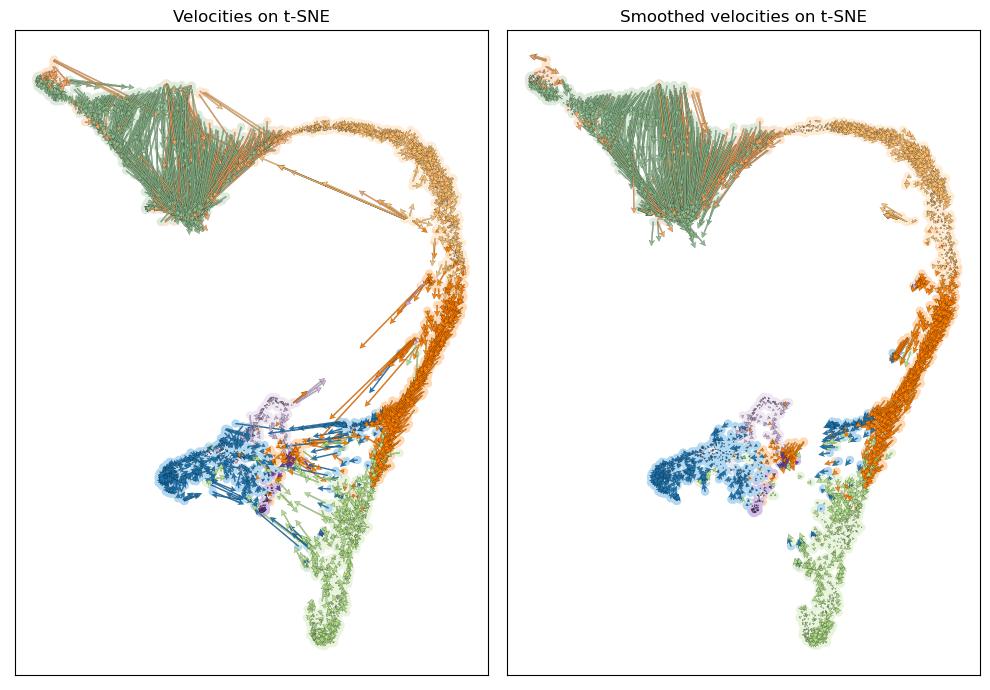

In [24]:
### create t-SNE plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].scatter(tSNE_data[:,0], tSNE_data[:,1], color=light_color, s=25)
axs[1].scatter(tSNE_data[:,0], tSNE_data[:,1], color=light_color, s=25)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

# title
axs[0].set_title("Velocities on t-SNE")
axs[1].set_title("Smoothed velocities on t-SNE")

# plot arrows 
axs[0].quiver(tSNE_data[:,0], tSNE_data[:,1], tSNE_v[:,0], tSNE_v[:,1], 
              color=cell_colors, **pca_quiver_kwargs)
axs[1].quiver(tSNE_data[:,0], tSNE_data[:,1], tSNE_v_mean[:,0], tSNE_v_mean[:,1], 
              color=cell_colors, **pca_quiver_kwargs)
plt.tight_layout()
plt.show()

### UMAP
**About UMAP**\
[UMAP](https://arxiv.org/abs/1802.03426) has two main parameters: `n_neighbors` that controls the size of the neighborhoods and `min_dis` that is used to stop "crowding" of points within too small a space in the embedding. `n_neighbors` has a very similar effect as t-SNE's perplexity

You can read more here: https://umap-learn.readthedocs.io/en/latest/parameters.html

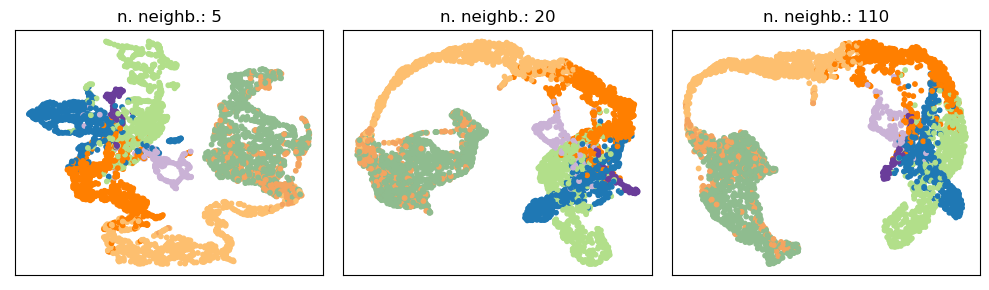

In [25]:
### set seed
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for i, n_neighbors in enumerate([5, 20, 110]):
    reducer = umap.UMAP(random_state=0, n_neighbors=n_neighbors, min_dist=.6, n_components=2, metric="euclidean")
    UMAP_data = reducer.fit_transform(pca_pts)
    axs[i].scatter(UMAP_data[:,0], UMAP_data[:,1], color=cell_colors, s=10)
    axs[i].set_xticks([]), axs[i].set_yticks([])
    axs[i].set_title("n. neighb.: " +str(n_neighbors))
plt.tight_layout()
plt.show()

In [26]:
### calculate UMAP 
reducer = umap.UMAP(random_state=0, n_neighbors=110, min_dist=.6, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_pts)

Calculate the projection of the velocities onto the UMAP embedding.

In [27]:
### calculate velocity projections
n_neighbors = 100
UMAP_fut = project_velocities(UMAP_data, pca_pts, pca_pts_fut, n_neighbors=n_neighbors)
UMAP_v = UMAP_fut-UMAP_data

Scaling velocities, set "force_no_scale=True" to stop this.
Projecting velocities using nystrom approach.


In [28]:
### smoothed velocities
UMAP_v_mean = np.nanmean(np.array(UMAP_v)[NN], axis=1)

Let's have a look!

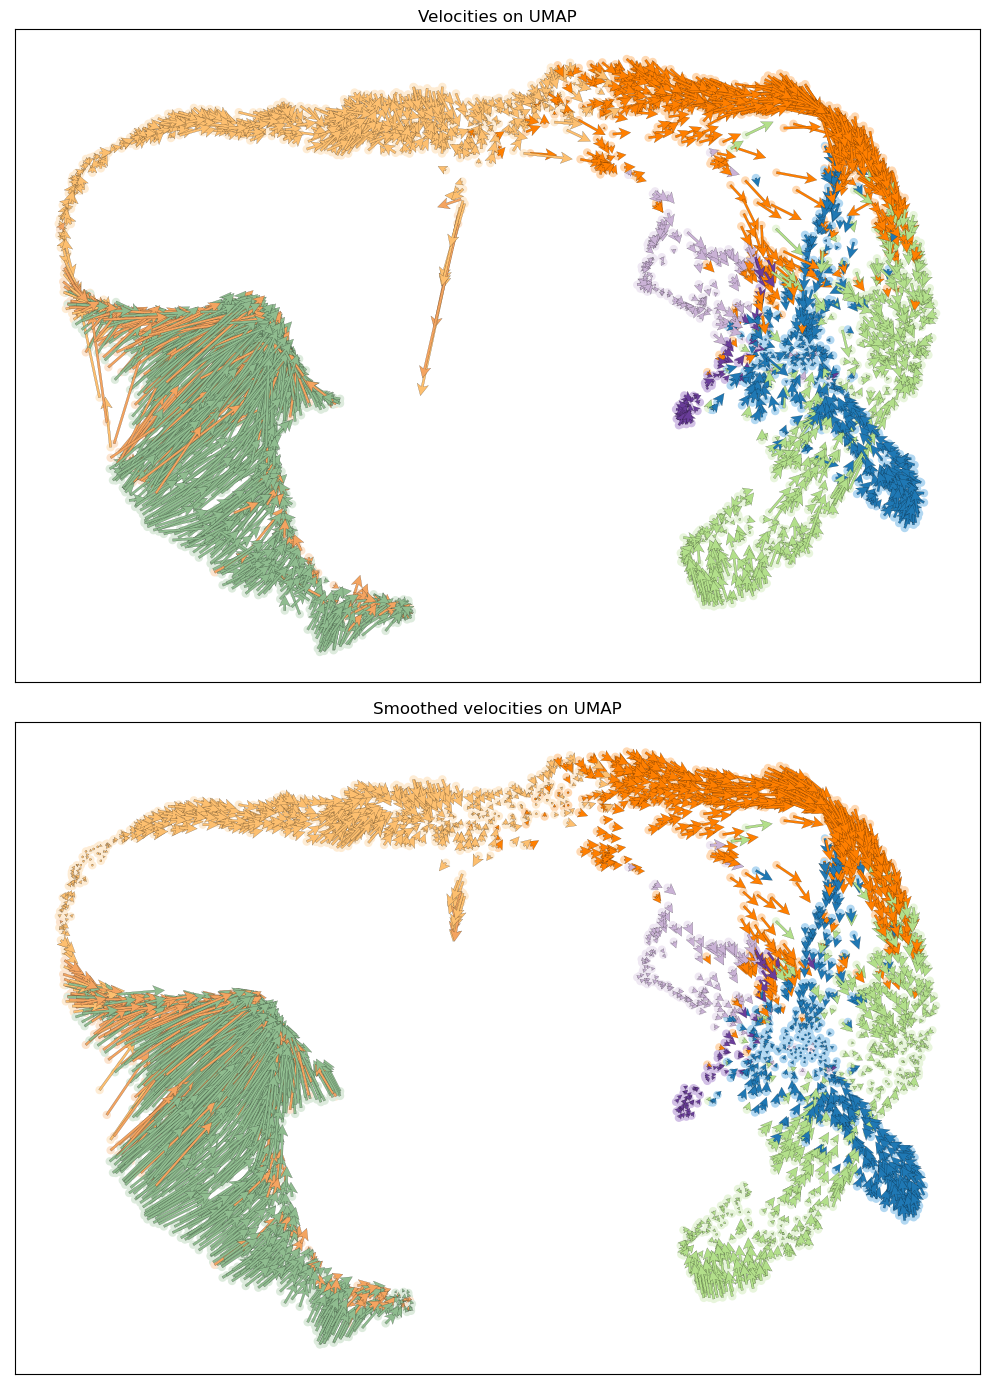

In [29]:
### create UMAP plot of pancreas by kappa-velo
fig, axs = plt.subplots(2, 1, figsize=(10, 14))

axs[0].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=25)
axs[1].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=25)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

# title
axs[0].set_title("Velocities on UMAP")
axs[1].set_title("Smoothed velocities on UMAP")

# plot arrows 
axs[0].quiver(UMAP_data[:,0], UMAP_data[:,1], UMAP_v[:,0], UMAP_v[:,1], 
              color=cell_colors, **pca_quiver_kwargs)
axs[1].quiver(UMAP_data[:,0], UMAP_data[:,1], UMAP_v_mean[:,0], UMAP_v_mean[:,1], 
              color=cell_colors, **pca_quiver_kwargs)
plt.tight_layout()
plt.show()